In [3]:
!pip install transformers
!pip install clean-text
from cleantext import clean
from transformers import RobertaTokenizer

import random
from sklearn.utils import shuffle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D,LSTM,Bidirectional, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
import tensorflow as tf
import nltk
from nltk import word_tokenize

import pandas as pd
import re
nltk.download('punkt')



#converting contracted words

def decontracted(phrase):
    
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


#cleaning text

def clean_t(text):
  x = clean(text,
      #fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=True,                  # replace all URLs with a special token
      no_emails=True,                # replace all email addresses with a special token
      no_phone_numbers=True,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=True,                 # remove punctuations
      replace_with_punct="",          # instead of removing punctuations you may replace them
      replace_with_url="<URL>",
      replace_with_email="<EMAIL>",
      replace_with_phone_number="<PHONE>",
      replace_with_number="<NUMBER>",
      replace_with_digit="0",
      replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
    )
  return decontracted(x)

#reading isear dataset and cleaning
df = pd.read_csv('/content/isear-en.csv', sep='\t')
emo_label = {i:i-1 for i in range(1,8)}
df['emotion1'] = df['emotion'].apply(lambda x: emo_label[x])
df['emotion'] = df['emotion1']
df['clean_text'] = df['text'].apply(lambda x: clean_t(x))
df['text'] = df['clean_text']
df.drop('clean_text', axis=1, inplace=True)
emo_label = {'joy':0, 'fear':1, 'anger':2, 'sadness':3, 'disgust':4, 'shame':5, 'guilt':6}



optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#split dataset to train and test set
from sklearn.model_selection import train_test_split
x_train, x_test ,y_train, y_test = train_test_split(list(df['text']), list(df['emotion']), test_size=0.2, train_size=0.8, shuffle=True,random_state=21)

In [5]:
#using roberta tokenizer to tokenize data
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
seq_len = 210

# tokenize - this time returning Numpy tensors
train_tokens = tokenizer(x_train, max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='tf')
test_tokens = tokenizer(x_test, max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='tf')

y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))

In [6]:
#substituting every word with its POS tag
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
X_train = [' '.join([x[1] for x in pos_tag(x_tr.split())]) for x_tr in x_train]
X_test = [' '.join([x[1] for x in pos_tag(x_tr.split())]) for x_tr in x_test]
# prepare tokenizer
import random
random.seed(42)
t = Tokenizer()
t.fit_on_texts(X_train+X_test)
vocab_size = len(t.word_index) + 1
# integer encode the documents
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
# pad documents to a max length of 4 words
max_length = 210
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
#substituting every word with its dependency parsing tag
import spacy
nlp = spacy.load('en_core_web_sm')
X_train1 = []
for x in x_train:
  doc = nlp(x)
  dep = [token.dep_ for token in doc]
  X_train1.append(dep)
X_train1 = [' '.join([x for x in X_t]) for X_t in X_train1]
#X_test = []
X_test1 = []
for x in x_test:
  doc = nlp(x)
  dep = [token.dep_ for token in doc]
#  pos = [token.tag_ for token in doc]
  X_test1.append(dep)
#  X_test.append(pos)
X_test1 = [' '.join([x for x in X_t]) for X_t in X_test1]
#X_test = [' '.join([x for x in X_t]) for X_t in X_test]
# prepare tokenizer
t1 = Tokenizer()
t1.fit_on_texts(X_train1+X_test1)
vocab_size1 = len(t1.word_index) + 1
# integer encode the documents
X_train1 = t1.texts_to_sequences(X_train1)
X_test1 = t1.texts_to_sequences(X_test1)
# pad documents to a max length of 4 words
max_length = 210
X_train1 = pad_sequences(X_train1, maxlen=max_length, padding='post')
X_test1 = pad_sequences(X_test1, maxlen=max_length, padding='post')

In [21]:
#Robetra with POS model
import tensorflow as tf
def create_model():
  np.random.seed(7)
  tf.random.set_seed(7)
  model3 = Sequential()
  bert = TFRobertaModel.from_pretrained('roberta-base')
  #bert.trainable = False
  # two input layers, we ensure layer name variables match to dictionary keys in TF dataset
  inputs1 = Input(shape=(210,))
  input_ids = tf.keras.layers.Input(shape=(210,), name='input_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(210,), name='attention_mask', dtype='int32')
  embeddings = bert(input_ids, mask)[1]  # access final activations (alread max-pooled) [1]
  embedding = tf.keras.layers.Embedding(vocab_size, 6)(inputs1)
  #lstm1 = Bidirectional(LSTM(64, return_sequences=False))(embedding)
  #lstm1 = Dropout(0.3)(lstm1)
  #lstm1 = MaxPooling1D(2,strides=2)(lstm1)
  #embeddings = Reshape((48,16))(embeddings)
  lstm1 = Flatten()(embedding)
  x = concatenate([embeddings, lstm1])
  #y = Flatten()(x)
  #y = tf.keras.layers.Dense(100, activation='relu')(y)
  #y = tf.keras.layers.Dropout(0.3)(y)
  y = tf.keras.layers.Dense(7, activation='softmax', name='outputs')(x)
  model3 = tf.keras.Model(inputs=[input_ids, mask, inputs1], outputs=y)
  return model3

In [22]:
from sklearn.utils.class_weight import compute_class_weight
y_ints = [y.argmax() for y in y_train]
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_ints), y= y_ints)
class_weight_dict = dict(enumerate(class_weights))

In [23]:
model1 = create_model()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5, decay=1e-6)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [24]:
history = model1.fit([train_tokens['input_ids'], train_tokens['attention_mask'], X_train], y_train, validation_data= ([test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test), shuffle=True,
              batch_size=16,
              epochs=2, class_weight=class_weight_dict) #, class_weight=class_weights
#evaluation(model1, [test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test)

Epoch 1/2
374/374 [==============================] - 316s 776ms/step - loss: 1.1477 - acc: 0.5705 - val_loss: 0.7656 - val_acc: 0.7490
Epoch 2/2
374/374 [==============================] - 304s 813ms/step - loss: 0.7020 - acc: 0.7578 - val_loss: 0.8124 - val_acc: 0.7383


In [25]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-7)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
history = model1.fit([train_tokens['input_ids'], train_tokens['attention_mask'], X_train], y_train, validation_data= ([test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test), shuffle=True,
              batch_size=16,
              epochs=2, class_weight=class_weight_dict) #, class_weight=class_weights
#evaluation(model1, [test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test)

Epoch 1/2
374/374 [==============================] - 306s 773ms/step - loss: 0.4075 - acc: 0.8718 - val_loss: 0.7759 - val_acc: 0.7497
Epoch 2/2
374/374 [==============================] - 304s 812ms/step - loss: 0.3200 - acc: 0.9068 - val_loss: 0.7765 - val_acc: 0.7564


In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



colors = ['#ffffff', '#fbcbff', '#707bfb']
cmap = LinearSegmentedColormap.from_list('mycmap', colors)


def evaluation(model, x_test, y_test):
    y_pred = model.predict([x_test], batch_size=16, verbose=1)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('f1-micro: ',f1_m(y_test, y_pred))
    print('precision-micro: ',precision_m(y_test, y_pred))
    print('recall-micro: ',recall_m(y_test, y_pred))
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cmn,cmap=cmap, annot=True, fmt='.2f',xticklabels=emo_label.keys(), yticklabels=emo_label.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    print('      confusion matrix')
    plt.show(block=False)

94/94 [==============================] - 25s 239ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       220
           1       0.84      0.82      0.83       239
           2       0.65      0.65      0.65       214
           3       0.77      0.79      0.78       209
           4       0.73      0.73      0.73       203
           5       0.65      0.62      0.63       193
           6       0.73      0.72      0.73       216

    accuracy                           0.76      1494
   macro avg       0.75      0.75      0.75      1494
weighted avg       0.75      0.76      0.76      1494

f1-micro:  tf.Tensor(0.75668067, shape=(), dtype=float32)
precision-micro:  tf.Tensor(0.79703707, shape=(), dtype=float32)
recall-micro:  tf.Tensor(0.7202142, shape=(), dtype=float32)
      confusion matrix


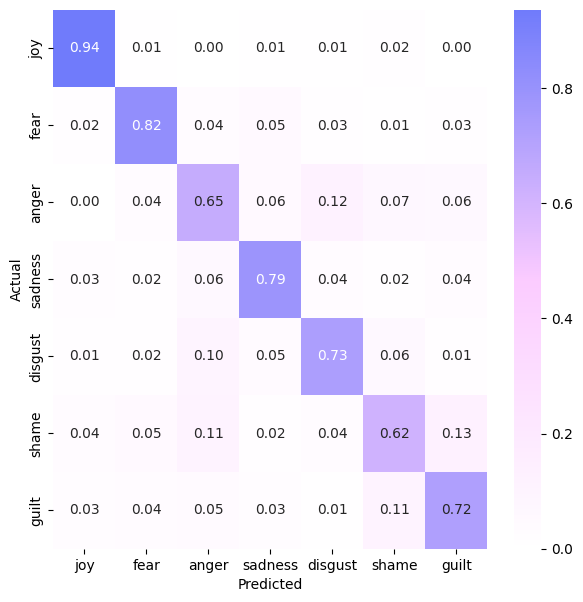

In [27]:
evaluation(model1, [test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test)

In [18]:
#Roberta with Dependency parsing tags
import tensorflow as tf
def create_model():
  np.random.seed(7)
  tf.random.set_seed(7)
  model3 = Sequential()
  bert = TFRobertaModel.from_pretrained('roberta-base')
  #bert.trainable = False
  # two input layers, we ensure layer name variables match to dictionary keys in TF dataset
  inputs1 = Input(shape=(210,))
  input_ids = tf.keras.layers.Input(shape=(210,), name='input_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(210,), name='attention_mask', dtype='int32')
  embeddings = bert(input_ids, mask)[1]  # access final activations (alread max-pooled) [1]
  embedding = tf.keras.layers.Embedding(vocab_size1, 6)(inputs1)
  #lstm1 = Bidirectional(LSTM(64, return_sequences=False))(embedding)
  #lstm1 = Dropout(0.3)(lstm1)
  #lstm1 = MaxPooling1D(2,strides=2)(lstm1)
  #embeddings = Reshape((48,16))(embeddings)
  lstm1 = Flatten()(embedding)
  x = concatenate([embeddings, lstm1])
  #y = Flatten()(x)
  #y = tf.keras.layers.Dense(100, activation='relu')(y)
  #y = tf.keras.layers.Dropout(0.3)(y)
  y = tf.keras.layers.Dense(7, activation='softmax', name='outputs')(x)
  model3 = tf.keras.Model(inputs=[input_ids, mask, inputs1], outputs=y)
  return model3

In [19]:
from sklearn.utils.class_weight import compute_class_weight
y_ints = [y.argmax() for y in y_train]
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_ints), y= y_ints)
class_weight_dict = dict(enumerate(class_weights))

In [20]:
model2 = create_model()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5, decay=1e-6)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
history = model2.fit([train_tokens['input_ids'], train_tokens['attention_mask'], X_train1], y_train, validation_data= ([test_tokens['input_ids'], test_tokens['attention_mask'], X_test1], y_test), shuffle=True,
              batch_size=16,
              epochs=2, class_weight=class_weight_dict) #, class_weight=class_weights
#evaluation(model1, [test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test)

Epoch 1/2
374/374 [==============================] - 331s 824ms/step - loss: 1.1790 - acc: 0.5646 - val_loss: 0.8010 - val_acc: 0.7242
Epoch 2/2
374/374 [==============================] - 305s 816ms/step - loss: 0.7159 - acc: 0.7484 - val_loss: 0.7919 - val_acc: 0.7450


In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-7)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
history = model2.fit([train_tokens['input_ids'], train_tokens['attention_mask'], X_train1], y_train, validation_data= ([test_tokens['input_ids'], test_tokens['attention_mask'], X_test1], y_test), shuffle=True,
              batch_size=16,
              epochs=2, class_weight=class_weight_dict) #, class_weight=class_weights
#evaluation(model1, [test_tokens['input_ids'], test_tokens['attention_mask'], X_test], y_test)

Epoch 1/2
374/374 [==============================] - 305s 771ms/step - loss: 0.4234 - acc: 0.8654 - val_loss: 0.7654 - val_acc: 0.7577
Epoch 2/2
374/374 [==============================] - 303s 811ms/step - loss: 0.3295 - acc: 0.9004 - val_loss: 0.7715 - val_acc: 0.7577


94/94 [==============================] - 31s 253ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       220
           1       0.87      0.83      0.85       239
           2       0.65      0.69      0.67       214
           3       0.77      0.77      0.77       209
           4       0.72      0.72      0.72       203
           5       0.66      0.63      0.65       193
           6       0.73      0.71      0.72       216

    accuracy                           0.76      1494
   macro avg       0.75      0.75      0.75      1494
weighted avg       0.76      0.76      0.76      1494

f1-micro:  tf.Tensor(0.75908285, shape=(), dtype=float32)
precision-micro:  tf.Tensor(0.8023863, shape=(), dtype=float32)
recall-micro:  tf.Tensor(0.7202142, shape=(), dtype=float32)
      confusion matrix


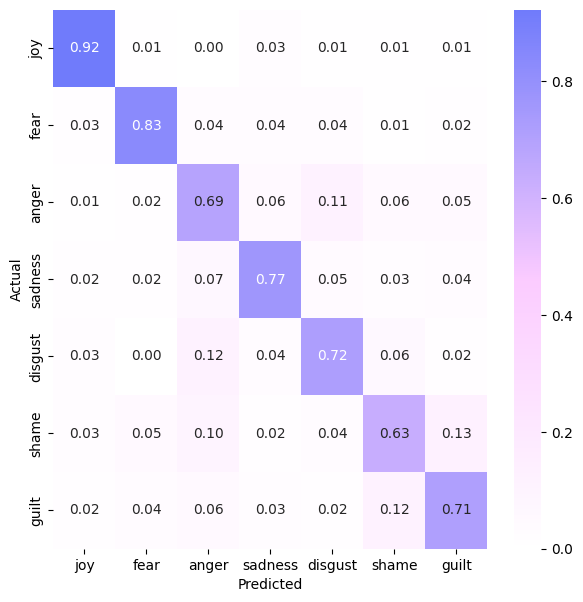

In [ ]:
evaluation(model2, [test_tokens['input_ids'], test_tokens['attention_mask'], X_test1], y_test)